# 车牌区域提取

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio
import math

In [143]:
src = imageio.imread('../datas/plate5.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

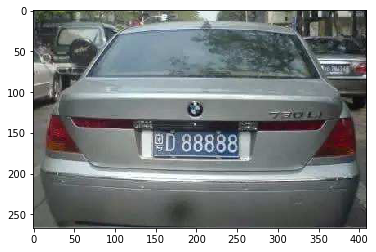

In [144]:
plt.imshow(src)

In [145]:
def point_limit(point):
	if point[0] < 0:
		point[0] = 0
	if point[1] < 0:
		point[1] = 0

In [146]:
#根据设定的阈值和图片直方图，找出波峰，用于分隔字符
def find_waves(threshold, histogram):
	up_point = -1#上升点
	is_peak = False
	if histogram[0] > threshold:
		up_point = 0
		is_peak = True
	wave_peaks = []
	for i,x in enumerate(histogram):
		if is_peak and x < threshold:
			if i - up_point > 2:
				is_peak = False
				wave_peaks.append((up_point, i))
		elif not is_peak and x >= threshold:
			is_peak = True
			up_point = i
	if is_peak and up_point != -1 and i - up_point > 4:
		wave_peaks.append((up_point, i))
	return wave_peaks

In [147]:
#根据找出的波峰，分隔图片，从而得到逐个字符图片
def seperate_card(img, waves):
	part_cards = []
	for wave in waves:
		part_cards.append(img[:, wave[0]:wave[1]])
	return part_cards

In [148]:
#来自opencv的sample，用于svm训练
def deskew(img):
	m = cv2.moments(img)
	if abs(m['mu02']) < 1e-2:
		return img.copy()
	skew = m['mu11']/m['mu02']
	M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
	img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
	return img

In [149]:
img = cv2.GaussianBlur(src, (3, 3), 0)#图片分辨率调整
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
oldimg = img.copy()

In [150]:
#去掉图像中不会是车牌的区域
kernel = np.ones((20, 20), np.uint8)
img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
img_opening = cv2.addWeighted(img, 1, img_opening, -1, 0)

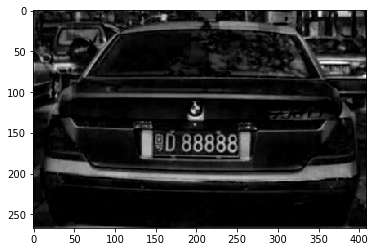

In [151]:
plt.imshow(img_opening,'gray')

In [152]:
#找到图像边缘
ret, img_thresh = cv2.threshold(img_opening, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_edge = cv2.Canny(img_thresh, 100, 200)
#使用开运算和闭运算让图像边缘成为一个整体
kernel = np.ones((5, 12), np.uint8)
img_edge1 = cv2.morphologyEx(img_edge, cv2.MORPH_CLOSE, kernel)
img_edge2 = cv2.morphologyEx(img_edge1, cv2.MORPH_OPEN, kernel)

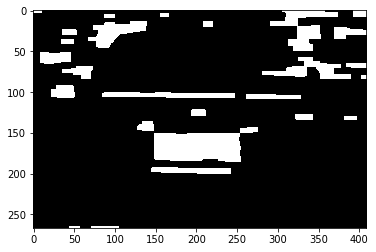

In [153]:
plt.imshow(img_edge2,'gray')

In [154]:
#查找图像边缘整体形成的矩形区域，可能有很多，车牌就在其中一个矩形区域中.
image, contours, hierarchy = cv2.findContours(img_edge2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 2000]
print('len(contours)', len(contours))

len(contours) 1


In [155]:
#一一排除不是车牌的矩形区域
car_contours = []
for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    area_width, area_height = rect[1]
    if area_width < area_height:
        area_width, area_height = area_height, area_width
    wh_ratio = area_width / area_height
    #要求矩形区域长宽比在2到5.5之间，2到5.5是车牌的长宽比，其余的矩形排除
    if wh_ratio > 2 and wh_ratio < 5.5:
        car_contours.append(rect)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
    print(len(car_contours))

1


In [156]:
 pic_width, pic_hight = img.shape
card_imgs = []
#矩形区域可能是倾斜的矩形，需要矫正，以便使用颜色定位
for rect in car_contours:
    if rect[2] > -1 and rect[2] < 1:#创造角度，使得左、高、右、低拿到正确的值
        angle = 1
    else:
        angle = rect[2]
    rect = (rect[0], (rect[1][0]+5, rect[1][1]+5), angle)#扩大范围，避免车牌边缘被排除
    box = cv2.boxPoints(rect)
    heigth_point = right_point = [0, 0]
    left_point = low_point = [pic_width, pic_hight]
    for point in box:
        if left_point[0] > point[0]:
            left_point = point
        if low_point[1] > point[1]:
            low_point = point
        if heigth_point[1] < point[1]:
            heigth_point = point
        if right_point[0] < point[0]:
            right_point = point
    if left_point[1] <= right_point[1]:#正角度
        new_right_point = [right_point[0], heigth_point[1]]
        pts2 = np.float32([left_point, heigth_point, new_right_point])#字符只是高度需要改变
        pts1 = np.float32([left_point, heigth_point, right_point])
        M = cv2.getAffineTransform(pts1, pts2)
        dst = cv2.warpAffine(oldimg, M, (pic_width, pic_hight))
        point_limit(new_right_point)
        point_limit(heigth_point)
        point_limit(left_point)
        card_img = dst[int(left_point[1]):int(heigth_point[1]), int(left_point[0]):int(new_right_point[0])]
        card_imgs.append(card_img)
    elif left_point[1] > right_point[1]:#负角度
        new_left_point = [left_point[0], heigth_point[1]]
        pts2 = np.float32([new_left_point, heigth_point, right_point])#字符只是高度需要改变
        pts1 = np.float32([left_point, heigth_point, right_point])
        M = cv2.getAffineTransform(pts1, pts2)
        dst = cv2.warpAffine(oldimg, M, (pic_width, pic_hight))
        point_limit(right_point)
        point_limit(heigth_point)
        point_limit(new_left_point)
        card_img = dst[int(right_point[1]):int(heigth_point[1]), int(new_left_point[0]):int(right_point[0])]
        card_imgs.append(card_img)
    

In [157]:
print(len(card_imgs))

1


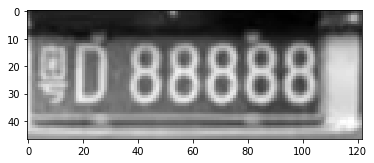

In [158]:
for i in range(len(card_imgs)):
    plt.figure()
    plt.imshow(card_imgs[i],'gray')